## High-z galaxies with Te measurements

# Determine metallicities using the direct method

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, 21))
markers = ('>','+','v','D','H','+','s','o','<','X','p','*','^','d','h','x','8','>','+','v','D','H')

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

# Quick look at all fluxes

In [2]:
# Load data
fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
fluxes.show_in_notebook()

idx,Name,E(B-V),eE(B-V),OIII1661,OIII1666,NIII1750,CIII1907,CIII1909,NeIII3869,OII3727,OII3729,OIITot,Hd,Hg,OIII4363,Hb,OIII4959,OIII5007,Ha,NII6584,eOIII1661,eOIII1666,eNIII1750,eCIII1907,eCIII1909,eNeIII3869,eOII3727,eOII3729,eOIITot,eHd,eHg,eOIII4363,eHb,eOIII4959,eOIII5007,eHa,eNII6584
0,CSWA20,0.0,-0.111694278081,0.04,0.1,nan,0.12,0.11,0.37,0.47,0.52,0.47,nan,0.57,0.05,1.0,1.67,4.97,3.32,0.06,0.04,0.04,nan,0.01,0.01,0.02,0.02,0.03,0.2,nan,0.05,0.03,0.07,0.1,0.29,0.2,0.02
1,USD-12539,0.0,0.0,nan,nan,nan,nan,nan,0.273398359934,0.610835735828,0.672093950698,1.28292968653,nan,0.243982685421,0.328823289936,1.0,nan,4.75605885627,3.38690273427,0.148764134562,nan,nan,nan,nan,nan,0.0528209815692,0.209371660572,0.24179061646,0.451161263944,nan,0.0204980009861,0.0292828497825,0.0434375917166,nan,0.148532612648,0.104606314142,0.012047127943
2,Abell_860_359,-0.00660535816973,0.0523637580861,0.0348145192369,0.0963110385075,0.0348422505775,nan,nan,nan,nan,nan,1.2668810541,nan,nan,nan,1.0,2.02091358022,6.07970038082,2.80506935141,nan,0.410940224141,0.294816141181,0.410954334913,nan,nan,nan,nan,nan,0.421692252295,nan,nan,nan,0.114473095752,0.181052446077,0.498185444248,0.237318565036,nan
3,Abell_22.3,-0.0849851343162,0.32165801836,nan,nan,nan,nan,nan,nan,nan,nan,1.11,nan,nan,0.27,1.0,1.98,6.45,5.03,0.05,nan,nan,nan,nan,nan,nan,nan,nan,0.3,nan,nan,0.1,0.1,0.3,0.3,0.4,0.025
4,RCSGA,0.246757337647,0.249348362587,nan,nan,nan,nan,nan,0.301830652593,nan,nan,2.85060296336,0.261962299772,0.470815675841,0.0520202185373,1.0,1.49058397736,4.76078072848,2.75414349351,0.175228331775,nan,nan,nan,nan,nan,0.00394140393647,nan,nan,0.0102146269734,0.00436212913341,0.00406222333437,0.00649632278896,0.00479297593159,0.00608252958964,0.0164831057354,0.00990438514102,0.00381476065566
5,A1689_31.1,0.169981272899,0.281928765512,0.153887959441,0.355702842685,nan,0.251181192609,0.487544714479,0.190177968487,0.280132256988,0.356145169765,0.636190944281,nan,0.452782431773,0.164159966625,1.0,1.44375700389,4.79746500295,nan,nan,0.00255961379902,0.00253486901945,nan,0.00246082512366,0.00264795994871,0.00404847840583,0.00271965744486,0.00276630636493,0.00312549368666,nan,0.00300234819267,0.00347934727575,0.00386119306963,0.00489582854016,0.0133506134979,nan,nan
6,SMACS_0304,-0.0219810071526,0.169088595575,0.022612068048,0.0371370546037,nan,nan,nan,0.351345299391,1.042960682,1.39858503106,2.50087582189,0.291287353618,0.448872841274,nan,1.0,1.31978998619,4.61474082811,2.99818852102,0.0963210408575,0.159926446345,0.147807233497,nan,nan,nan,6.19518380722,1.90542424915,1.63578321597,0.321174303372,0.126234131463,0.131833606218,nan,0.168105570301,0.196619246411,0.561167444927,0.373674914368,0.114772543797
7,MACS_0451,0.255105931567,-0.0659180038683,0.2,0.3,0.1,nan,nan,nan,nan,nan,0.63,nan,nan,nan,1.0,1.37,3.95,2.58,0.065,0.1,0.1,0.05,nan,nan,nan,nan,nan,0.315,nan,nan,nan,0.1,0.05,0.05,0.16,0.0325
8,COSMOS_12805,0.242291552144,0.0266391634172,0.049,0.075,0.042,nan,nan,nan,nan,nan,2.9,nan,nan,nan,1.0,1.89,6.46,2.84,0.1,0.012,0.015,0.021,nan,nan,nan,nan,nan,1.45,nan,nan,nan,0.3,0.42,0.29,0.05,0.05
9,BX660,0.0,-0.0361146083644,0.0,0.21,nan,nan,nan,nan,nan,nan,0.87,nan,nan,nan,1.0,3.2,6.4,2.77,0.07,0.0,0.04,nan,nan,nan,nan,nan,nan,0.04,nan,nan,nan,0.5,0.8,0.3,0.2,0.035


## Using PyNeb/Izotov2006

In [12]:
## Temperatures from Izotov 2009
def Izotov06_TOIII(f,t):
    """ Equation 1 of Izotov 2006. Only works if OIII4663 is seen. Neglecting density.
    """
    t *= 1e-4
    CT = 8.44 - 1.09*t + 0.5*t**2 - 0.08*t**3 # Here we are neglecting the density
    new_t = 1.432 /(np.log10((f['OIII4959'] + f['OIII5007'])/f['OIII4363']) - np.log10(CT))
    return new_t * 1e4

def calculate_TOIII(f):
    
    params = Parameters()
    params.add('t', value=10000., min=1000., max=30000.)
    
    def fnc(params,f):
        t = params['t']
        return t - Izotov06_TOIII(f,t)
    
    fit = minimize(fnc, params,args=(f,),method='least_squares')
    
    return fit.params['t'].value
    
    
def Izotov06_TOII(tOIII,Z='intermediate'):
    """Equation 14 of Izotov 2006. The dispersion of this relation is not provided
    """
    tOIII *= 1e-4 
    if Z == 'low': # 7.2
        return (-0.577 + tOIII * (2.065 - 0.498*tOIII))*1e4 
    elif Z == 'intermediate': #7.6
         return (-0.744 + tOIII * (2.338 - 0.610*tOIII))*1e4 
    elif Z == 'high': # 8.2
        return (2.967 + tOIII * (-4.797 + 2.827*tOIII))*1e4 
    else:
        print('Wrong "Z" option')

In [29]:
# Calculate metallicities
import pyneb as pn
pn.atomicData.setDataFile('o_iii_coll_AK99.dat') # have to change because the default ones do not have level 6
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O',2)

dered_fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
Te_data = Table.read('data_Te.dat',format='ascii.fixed_width_two_line')
Te_data.add_index('Name')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []

def sum_met(OH,O2H):
    return 12 + np.log10(10**(OH-12)+10**(O2H-12))

for f in dered_fluxes:
    
    Te = Te_data.loc[f['Name']]['Te']
    Den = Te_data.loc[f['Name']]['Den']
    
    #  Calculate TOII. take our estimated temperatures as TOIII.
    t_low = (Izotov06_TOII(Te,Z='low')) # May need to change the Z
    t_inter = (Izotov06_TOII(Te,Z='intermediate')) # May need to change the Z
    t_high = (Izotov06_TOII(Te,Z='high')) # May need to change the Z

    def change_scale(x):
        return 12+np.log10(x)
    
    # Calculate metalliticites
    O2_H_pyneb.append(change_scale(O3.getIonAbundance((f['OIII4959']+f['OIII5007']),Te,Den,
                                                to_eval='L(4959)+L(5007)',Hbeta=f['Hb'])))
    O_H_pyneb.append(change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den,
                                                     to_eval='L(3726)+L(3729)',Hbeta=f['Hb'])))
    met_pyneb.append(sum_met(O2_H_pyneb[-1],O_H_pyneb[-1]))
    
    a = change_scale(O2.getIonAbundance((f['OIITot']),t_low,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    b = change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    c = change_scale(O2.getIonAbundance((f['OIITot']),t_high,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))

    print(a,b,c)
    
    
print('                Name\tO/H\tO+2/H\tMetOH')
for i,f in enumerate(dered_fluxes):
    print('%20s\t%0.2f\t%0.2f\t%0.2f'%(f['Name'],O_H_pyneb[i],O2_H_pyneb[i],met_pyneb[i]))


(7.0804541504436562, 7.0833042456402495, 7.0399593840388368)
(9.3804946377961791, nan, nan)
(7.2887072800346733, 7.2900045870149679, 7.0735111694889019)
(7.0105627421629633, 7.2236412111828674, nan)
(7.7221904854516508, 7.7231289765486197, 7.593545001006782)
(6.6832438845395732, 6.7510312561503012, nan)
(7.8840467133725252, 7.8876087022539982, 7.8550253705806874)
(6.6874651128039311, 6.7243563752548345, nan)
(7.7641912376558491, 7.7654269319526126, 7.6656342571434433)
(6.9825213815651921, 6.9897591332007343, 6.5280222502150629)
(7.1830525219182766, 7.1852372296731435, 6.9018007814944378)
(7.1146936018962759, 7.1163399515067178, 6.8622959442997029)
(7.7404792114066252, 7.7414160434463959, 7.6112490566076234)
(6.8067891161785417, 6.8105457105394223, 6.4612941248354749)
(7.6221953121062027, 7.6405957150960822, 7.5722802323117682)
                Name	O/H	O+2/H	MetOH
              CSWA20	7.08	8.10	8.14
           USD-12539	nan	nan	nan
       Abell_860_359	7.29	8.01	8.09
          Abell_22.

# How to get an error using Pyned? 

Using MC? 

    1) Draw an E(B-V)
    2) Dered the lines
    3) Draw a temperature and a density
    4) Calculate the metalllicity

repeat for a couple of times?

In [32]:
# Calculate metallicities with error estimation
from astropy.visualization import hist
import pickle
galaxies = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []
upO_H_pyneb = []
upO2_H_pyneb = []
upmet_pyneb = []
lowO_H_pyneb = []
lowO2_H_pyneb = []
lowmet_pyneb = []

def change_scale(x):
    return 12+np.log10(x)

print('                Name\t       O/H\t\t       O+2/H\t\t      MetOH')
for gal in galaxies:
    
    # Open flux files
    dered_f = pickle.load( open( 'dered_f_samples/'+gal['Name']+"_flux_samples.pickle", "rb" ) )
    O2_H_sample = []
    O_H_sample = []
    
    #  Sample of densitties and TOIII. Calculate TOII
    tem_and_den    = pickle.load( open( 'tem_and_ebv_samples/'+gal['Name']+"_tem_and_ebv.pickle", "rb" ) )
    tOIII_sample  = np.random.choice(tem_and_den['tem'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Te'])
    den_sample    = np.random.choice(tem_and_den['den'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Den'])  
    tOII_sample   = np.array([Izotov06_TOII(x,Z='low') for x in tOIII_sample]) # May need to change the Z
    
    ## Calculate metalliticites
    O2_H_sample.append(O3.getIonAbundance(np.array(dered_f['OIII4959'])+np.array(dered_f['OIII5007']),
                                          tOIII_sample,den_sample,to_eval='L(4959)+L(5007)',Hbeta=dered_f['Hb']))
    O_H_sample.append(O2.getIonAbundance(np.array(dered_f['OIITot']),
                                          tOII_sample,den_sample,
                                          to_eval='L(3726)+L(3729)',Hbeta=dered_f['Hb']))
    
    total = np.array([change_scale(m1+m2) for  m1,m2 in zip(O2_H_sample,O_H_sample)])
    O2_H_sample = np.array([change_scale(m) for  m in O2_H_sample])
    O_H_sample  = np.array([change_scale(m) for  m in O_H_sample])
    
    O2_H_pyneb.append(np.nanpercentile(O2_H_sample,50))
    O_H_pyneb.append(np.nanpercentile(O_H_sample,50)) 
    upO2_H_pyneb.append(np.nanpercentile(O2_H_sample,84)-np.nanpercentile(O2_H_sample,50))
    upO_H_pyneb.append(np.nanpercentile(O_H_sample,84)-np.nanpercentile(O_H_sample,50))
    lowO2_H_pyneb.append(np.nanpercentile(O2_H_sample,50)-np.nanpercentile(O2_H_sample,16))
    lowO_H_pyneb.append(np.nanpercentile(O_H_sample,50)-np.nanpercentile(O_H_sample,16))
    met_pyneb.append(np.nanpercentile(total,50))
    upmet_pyneb.append(np.nanpercentile(total,84)-np.nanpercentile(total,50))
    lowmet_pyneb.append(np.nanpercentile(total,50)-np.nanpercentile(total,16))

    print('%20s\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f'%(gal['Name'],
                                                               O_H_pyneb[-1],upO_H_pyneb[-1],lowO_H_pyneb[-1],
                                                               O2_H_pyneb[-1],upO2_H_pyneb[-1],lowO2_H_pyneb[-1],
                                                              met_pyneb[-1],upmet_pyneb[-1],lowmet_pyneb[-1]))


                Name	       O/H		       O+2/H		      MetOH
              CSWA20	7.02 + 0.44 - 0.24	8.09 + 0.33 - 0.21	8.13 + 0.34 - 0.22
           USD-12539	8.91 + 2.96 - 1.01	nan + nan - nan	nan + nan - nan
       Abell_860_359	7.28 + 0.15 - 0.10	8.01 + 0.14 - 0.10	8.08 + 0.14 - 0.10
          Abell_22.3	7.19 + 0.32 - 0.24	7.37 + 0.15 - 0.09	7.60 + 0.09 - 0.07
               RCSGA	7.74 + 0.33 - 0.19	7.99 + 0.24 - 0.18	8.18 + 0.27 - 0.17
          A1689_31.1	6.73 + 0.18 - 0.14	7.39 + 0.18 - 0.14	7.48 + 0.16 - 0.09
          SMACS_0304	7.90 + 0.20 - 0.10	8.07 + 0.06 - 0.05	8.31 + 0.11 - 0.07
           MACS_0451	6.68 + 0.09 - 0.07	7.44 + 0.15 - 0.14	7.51 + 0.13 - 0.13
        COSMOS_12805	7.75 + 0.30 - 0.27	8.12 + 0.22 - 0.31	8.28 + 0.22 - 0.30
               BX660	7.01 + 0.33 - 0.24	7.94 + 0.31 - 0.26	7.99 + 0.32 - 0.22
                BX74	7.23 + 0.35 - 0.28	8.06 + 0.25 - 0.41	8.14 + 0.25 - 0.40
               BX418	7.16 + 0.42 - 0.30	8.05 + 0.28 - 0.35	8.11 + 0.30 - 0.32
           

In [39]:
## Save results in a table 
pyneb_out = Table([dered_fluxes['Name'],
                   O_H_pyneb,upO_H_pyneb,lowO_H_pyneb,
                   O2_H_pyneb,upO2_H_pyneb,lowO2_H_pyneb,
                   met_pyneb,upmet_pyneb,lowmet_pyneb],
                names = ['Name','O/H','upO/H','lowO/H','O2/H','upO2/H','lowO2/H','met','upmet','lowmet'])

pyneb_out.write('pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
pyneb_out.show_in_notebook() 

idx,Name,O/H,upO/H,lowO/H,O2/H,upO2/H,lowO2/H,met,upmet,lowmet
0,CSWA20,7.02064020122,0.444220201632,0.243750786221,8.09228724777,0.330481314052,0.21316803559,8.12794629357,0.34241856735,0.215934511225
1,USD-12539,8.91014326501,2.95791275055,1.01362081652,nan,nan,nan,nan,nan,nan
2,Abell_860_359,7.28264168741,0.147344181536,0.0955658814364,8.0074305506,0.138075225809,0.102883729559,8.08143130106,0.13843836058,0.0999187885692
3,Abell_22.3,7.18896861937,0.316074038845,0.236925950127,7.36571449262,0.145848178327,0.0925661650323,7.59934357192,0.0872429584632,0.0670185638182
4,RCSGA,7.7353499713,0.328005640689,0.18973333181,7.98677845601,0.239774649516,0.176079941707,8.17835389314,0.267650234042,0.169606456545
5,A1689_31.1,6.73385519607,0.181483431823,0.135692499335,7.39402251977,0.180860759921,0.140222239282,7.47905697863,0.159375349763,0.0877424220286
6,SMACS_0304,7.90298535431,0.202004633136,0.102570258902,8.07062048958,0.0586527571714,0.0495012472211,8.30530040769,0.106576749035,0.0709298974552
7,MACS_0451,6.6831898098,0.0936635576682,0.0708423315427,7.44488044801,0.145791119143,0.144601477812,7.51366984289,0.131199352483,0.126429772924
8,COSMOS_12805,7.74578693636,0.304705480323,0.273533500303,8.11743972376,0.217890168708,0.310367714617,8.27939723852,0.222281198086,0.2970177682
9,BX660,7.00911208906,0.332800442948,0.235350072232,7.93846489184,0.313279790137,0.259124781109,7.9899295314,0.324113990271,0.219278838056


In [45]:
## Write it to paper 

out = open('TeMethod_pyneb_for_paper','w')

out.write('Obj          \t& 12+log (O$^+$/H$^+$) \t& 12+log(O$^{2+}$/H$^+$) \t& 12+log(O/H)$_{\Te}$ \\\\ \n')

for f in pyneb_out:
    out.write("%s \t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t \\\\ \n"
                  %(f['Name'],f['O/H'],f['upO/H'],f['lowO/H'],
                    f['O2/H'],f['upO2/H'],f['lowO2/H'],
                    f['met'],f['upmet'],f['lowmet']))
                    
out.close()

<IPython.core.display.Javascript object>


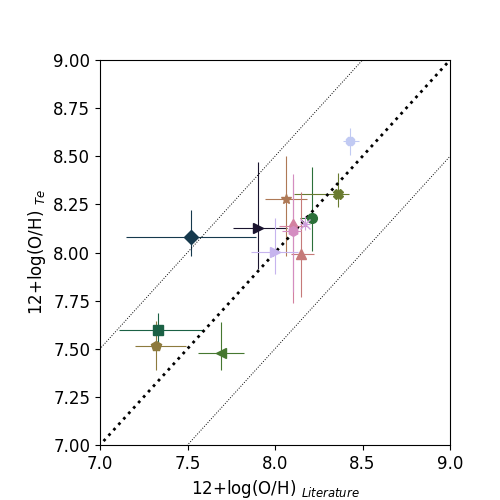

In [69]:
# Compare with previous estimations
plt.rcParams.update({'font.size': 12})
properties = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
properties.add_index('Name')

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(properties['Name'])))
properties.remove_row(3)

#plotting
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.2)

for i,gal in enumerate(properties):    
    ax.errorbar(gal['MetTe'],met_pyneb[i],label=gal['Name'],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),
                yerr=np.array((lowmet_pyneb[i],upmet_pyneb[i])).reshape(2,1),
                color=colors[gal['nb']],marker=gal['marker'],
                markersize=7,elinewidth=0.8)

ax.plot(np.arange(6.0,10.),np.arange(6.0,10.),color='k',linewidth=2.0,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)+0.5,color='k',linewidth=0.7,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)-0.5,color='k',linewidth=0.7,linestyle=':')
ax.set_ylabel('12+log(O/H) $_{Te}$')
ax.set_xlabel('12+log(O/H) $_{Literature}$')
ax.set_ylim(7.0,9.0)
ax.set_xlim(7.0,9.0)

fig.savefig('/Users/vera/Desktop/DirectMethod_Lit.pdf')
